In [1]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
global_dpi = 150
mpl.rcParams['figure.dpi']= global_dpi
import copy
import random
import numba
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import eigs as eig
from scipy.sparse.linalg import eigsh
import scipy.integrate as integrate
import scipy
import scipy.linalg as linalg

# Finding eigenfunctions of the wave equation using the finite difference method

In [2]:
@numba.njit(parallel=True, fastmath=True)
def wave_matrix(include_matrix, dx):
    positions = []
    for y in range(include_matrix.shape[0]):
        for x in range(include_matrix.shape[1]):
            if include_matrix[y,x] == 1:
                positions.append([y,x])
    matrix = np.zeros((len(positions),len(positions)))
    plus_minus = [np.array([-1,0]),np.array([+1,0]),np.array([0,-1]),np.array([0,+1])]
    counter = 0
    for i in positions:
        vector = np.zeros((len(positions)))
        vector[positions.index(i)] = -4/(dx**2)
        for k in plus_minus:
            cache_list = [np.array(i)[0] + k[0],np.array(i)[1] + k[1]]
            if cache_list in positions:
                vector[positions.index(cache_list)] = 1/(dx**2)
        matrix[counter,:] = vector.copy()
        counter = counter + 1
    return matrix



def eigenvector_to_matrix(eigenvector, include_matrix, source = False ,source_pos = None):
    if not source: 
        matrix = []
        counter = 0
        for y in range(include_matrix.shape[0]):
            cache = []
            for x in range(include_matrix.shape[1]):
                if include_matrix[y,x] == 1:
                    cache.append(eigenvector[counter])
                    counter = counter + 1
                else:
                    cache.append(0)
            cache = np.asarray(cache)
            matrix.append(cache.copy())  
        matrix = np.asarray(matrix)
    if source:
        matrix = []
        counter = 0
        for y in range(include_matrix.shape[0]):
            cache = []
            for x in range(include_matrix.shape[1]):
                if include_matrix[y,x] == 1:
                    cache.append(eigenvector[counter])
                    counter = counter + 1
                else:
                    cache.append(0)
            cache = np.asarray(cache)
            matrix.append(cache.copy())
        matrix = np.asarray(matrix)
        matrix[source_pos[0],source_pos[1]] = 1
    return matrix

def sorter(eigenvalues, eigenvectors):
    values = eigenvalues.copy()
    vectors = eigenvectors.copy().T
    cache_values = values.copy()
    cache_vector = vectors.copy()
    values.sort()
    values = values.tolist()
    mapper = np.zeros((len(values)))
    counter = 0
    for i in cache_values:
        mapper[counter] = values.index(i)
        counter = counter + 1
    counter = 0
    mapper = [int(i) for i in mapper]
    for i in mapper:
        vectors[i] = cache_vector[counter].copy()
        counter = counter + 1
    return np.array(values), vectors.T
 
def shape_creator(L, dims, shape):
    if shape == 'Square':
        include_matrix = np.zeros((dims,dims))
        include_matrix[1:dims-1,1:dims-1] = np.ones((dims-2,dims-2))
        dx = L/(dims)
        x = np.linspace(0,L,include_matrix.shape[1])
        y = np.linspace(0,L,include_matrix.shape[0])
        X,Y = np.meshgrid(x,y)
    elif shape == 'Rectangle':
        include_matrix = np.zeros((dims,2*dims))
        include_matrix[1:dims-1,1:2*dims-1] = np.ones((dims-2,2*dims-2))
        dx = L/(dims)
        x = np.linspace(0,2*L,include_matrix.shape[1])
        y = np.linspace(0,L,include_matrix.shape[0])
        X,Y = np.meshgrid(x,y)
    elif shape == 'Circle':
        include_matrix = np.zeros((dims,dims))
        circle_matrix = np.zeros((dims-2,dims-2))
        circle_dims = dims-2
        for y in range(circle_matrix.shape[0]):
            for x in range(circle_matrix.shape[1]):
                if np.sqrt((x+1/2-(circle_dims)/2)**2 + (y+1/2-(circle_dims)/2)**2) <= (circle_dims)/2:
                    circle_matrix[y,x] = 1
        dx = L/(dims)
        include_matrix[1:-1,1:-1] = circle_matrix
        x = np.linspace(0,L,include_matrix.shape[1])
        y = np.linspace(0,L,include_matrix.shape[0])
        X,Y = np.meshgrid(x,y)
    else:
        print('Shape not supported')
    return dx, include_matrix, X,Y



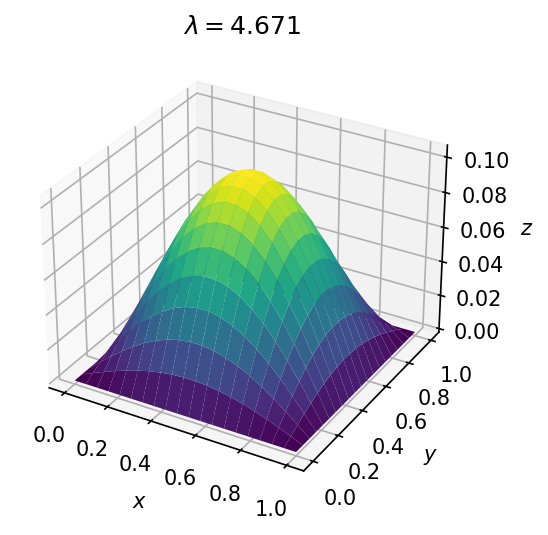

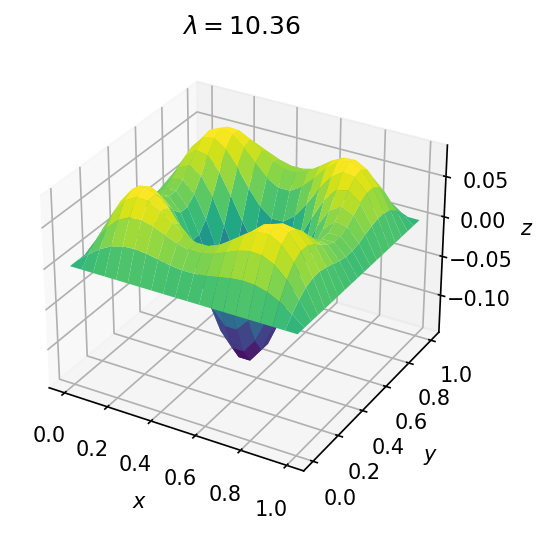

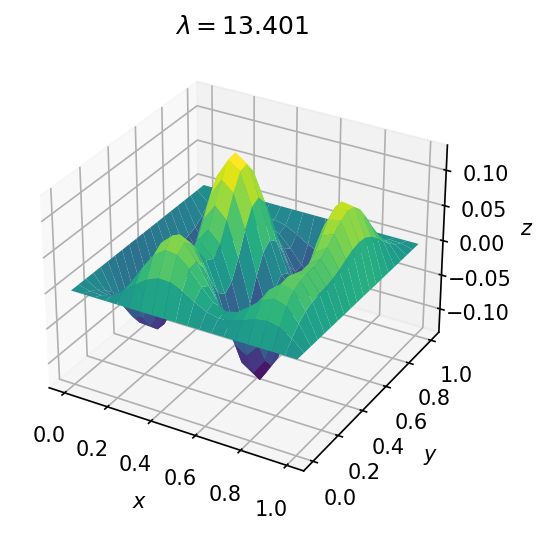

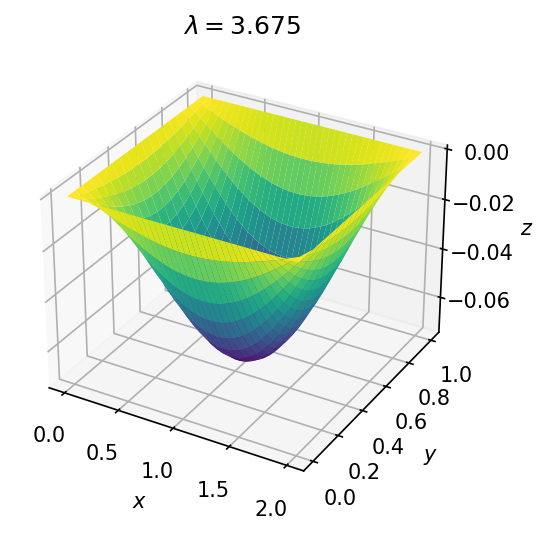

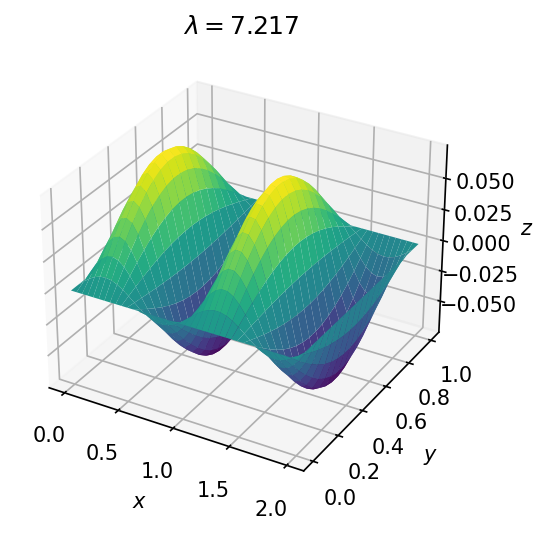

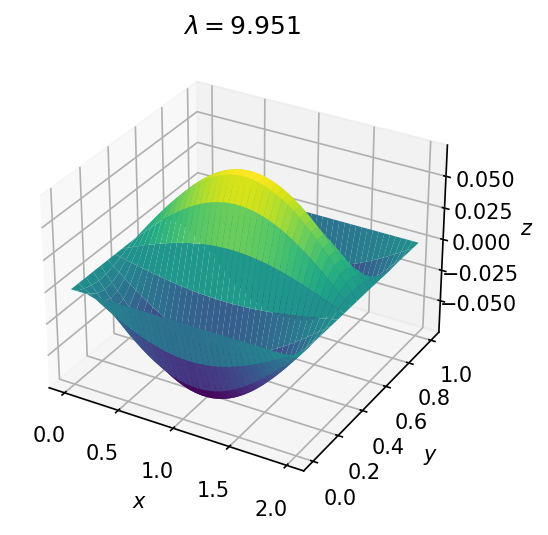

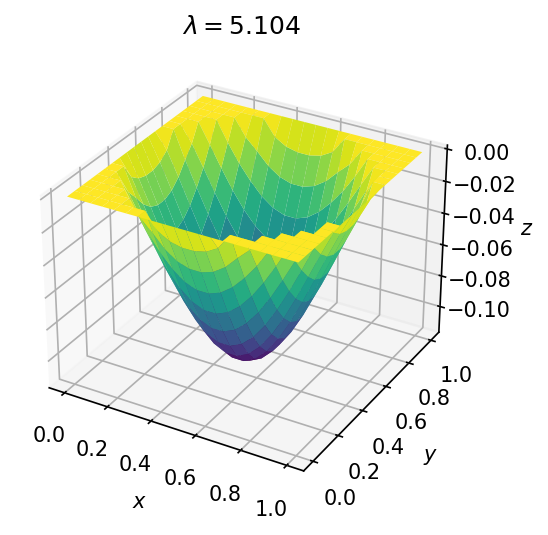

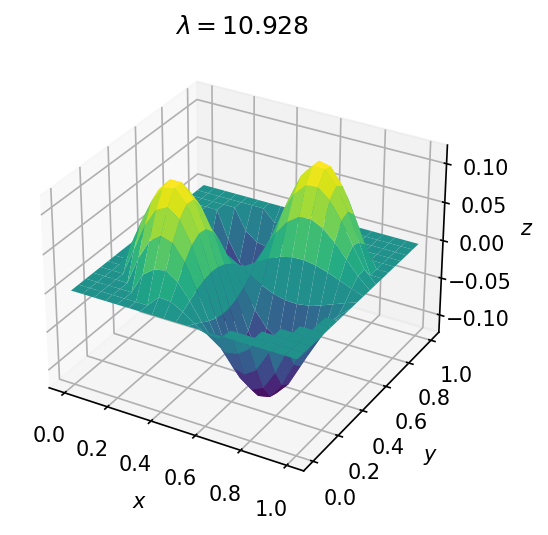

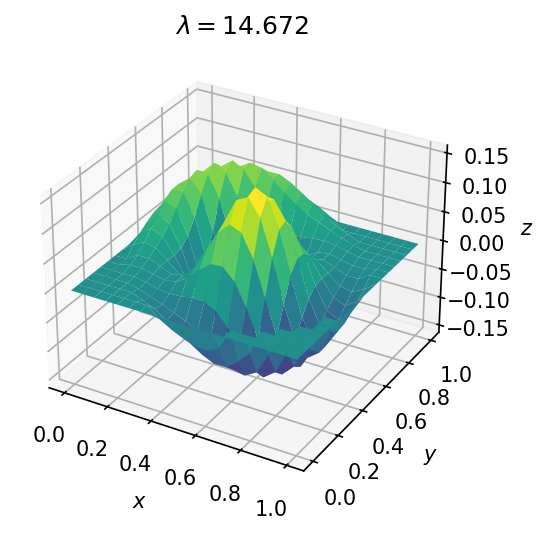

In [3]:
dims = 20
L = 1
k = 20
plot_list = [-1,-5,-10] # plot the 1st, 5th, and 10th eigenvalue for each of the geometries
shape_list = ['Square','Rectangle','Circle']
for shape in shape_list:
    for p in plot_list:
        dx, include_matrix,X,Y = shape_creator(L,dims,shape = shape)
        matrix = wave_matrix(include_matrix,dx)
        eigen = eig(matrix, k = k, which = 'SM')


        eigenvalues = np.real(eigen[0])
        eigenvectors = np.real(eigen[1])
        eigenvalues, eigenvectors = sorter(eigenvalues, eigenvectors)
        solution = eigenvector_to_matrix(eigenvectors[:,p],include_matrix)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        Axes3D.plot_surface(ax, X,Y,solution, cmap = 'viridis')
        ax.set_ylabel('$y$')
        ax.set_xlabel('$x$')
        ax.set_zlabel('$z$')
        ax.set_title('$λ = ' + str(np.round(np.sqrt(-eigenvalues[p]),3)) + '$')
        
        #if shape == 'Rectangle':
        #    plt.xticks(np.linspace(0,2,5),np.linspace(0,2,5))
        #plt.savefig(str(shape) + ', ' + str(p))
        plt.show()
    

# Solving the time-independent Schrödinger equation using the finite difference method

In [5]:
def vector_creator(L,dims,a, potential, pot_a, function = False, b = None):
    assert dims/2 - dims//2 == 0
    assert 1/2* L >= a and 1/2*L >= pot_a
    dx = L/dims
    vector = np.zeros((dims))
    pot_vector = np.ones((dims))
    size = np.floor((a/L)*dims)
    pot_size = np.floor((pot_a/L)*dims)
    pos = dims/2 - size
    pos = int(pos)
    pot_pos = dims/2 - pot_size
    pot_pos = int(pot_size)
    vector[pos:-pos] = 1
    if pos == 0:
        vector = np.ones((vector.shape[0]))
    pot_vector[pot_pos:-pot_pos] = 0
    if pot_pos == 0:
        pot_vector = np.zeros((pot_vector.shape[0]))
    V = potential*pot_vector.copy()
    if function:
        V = b*np.linspace(-1/2*L,1/2*L,dims)**2
    return vector,dx, V

def vector_to_matrix(vector,dx ,V = None ,infinite = True):
    if infinite:
        assert 0 in vector
        dims = vector.shape[0]
        size = 0
        for i in vector:
                if i == 1:
                    size = size + 1
        matrix = np.zeros((size,size))
        counter = 0
        for i in matrix:
            if counter != 0 and counter != i.shape[0] - 1:
                i[counter] = 1/dx**2
                i[counter+1] = -(1/2)/dx**2
                i[counter-1] = -(1/2)/dx**2
            elif counter == 0:
                i[counter] = 1/dx**2
                i[counter+1] = -(1/2)/dx**2
            elif counter == i.shape[0] - 1:
                i[counter] = 1/dx**2
                i[counter-1] = -(1/2)/dx**2
            counter = counter + 1
        eigs = scipy.linalg.eig(matrix)
        eigenvectors = eigs[1].T.copy()
        diff = 1/2*dims - 1/2*size
        diff = int(diff)
        final_eigenvectors = np.zeros((eigenvectors.shape[0],dims))
        counter = 0
        for i in eigenvectors:
            final_eigenvectors[counter,diff:-diff] = i.copy()
            counter = counter + 1
        return np.real(eigs[0]), final_eigenvectors.T
    
    if not infinite:
        matrix = np.zeros((vector.shape[0],vector.shape[0]))
        counter = 0
        for i in matrix:
            if counter != 0 and counter != i.shape[0] - 1:
                i[counter] = 1/dx**2 + V[counter]
                i[counter+1] = -(1/2)/dx**2
                i[counter-1] = -(1/2)/dx**2
            elif counter == 0:
                i[counter] = 1/dx**2 + V[counter]
                i[counter+1] = -(1/2)/dx**2
            elif counter == i.shape[0] - 1:
                i[counter] = 1/dx**2 + V[counter]
                i[counter-1] = -(1/2)/dx**2
            counter = counter + 1
        eigs = scipy.linalg.eig(matrix)
        
        return np.real(eigs[0]), eigs[1]
    
def analytic(a,n,x):
    return np.sqrt(1/a)*np.sin(n*np.pi*(x+a)/(a*2))



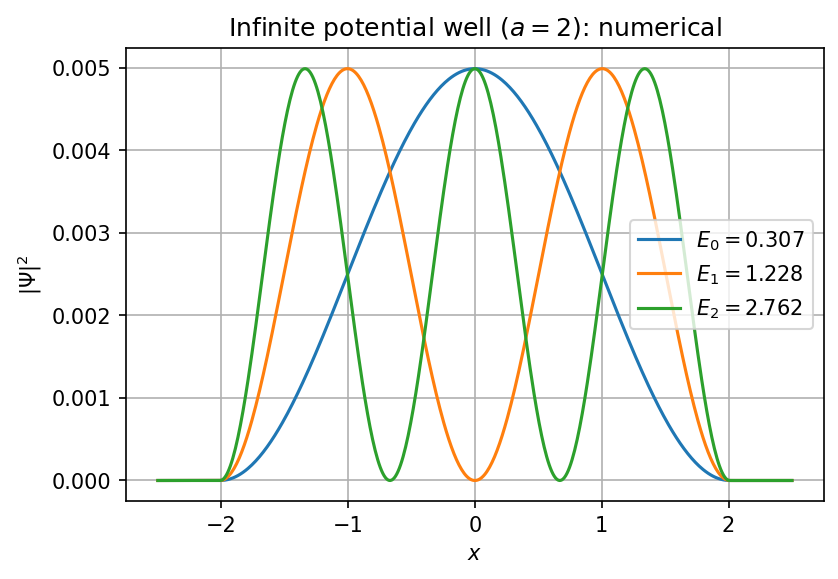

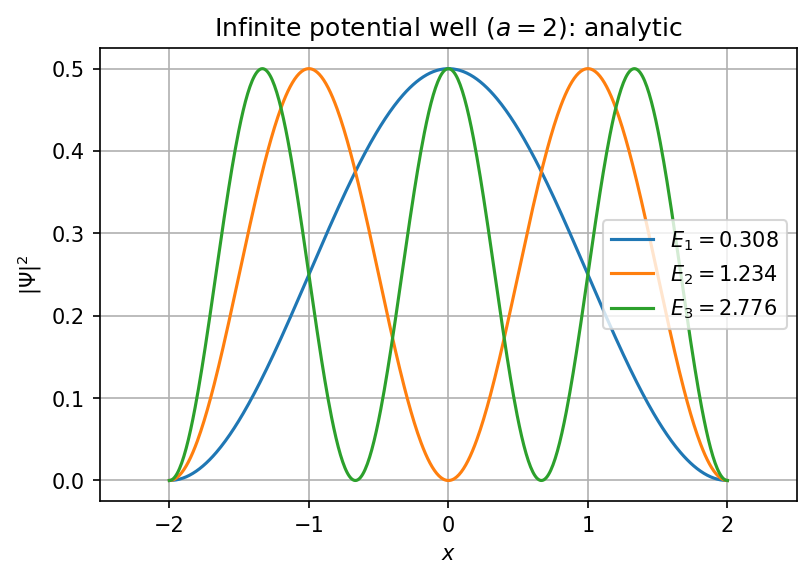

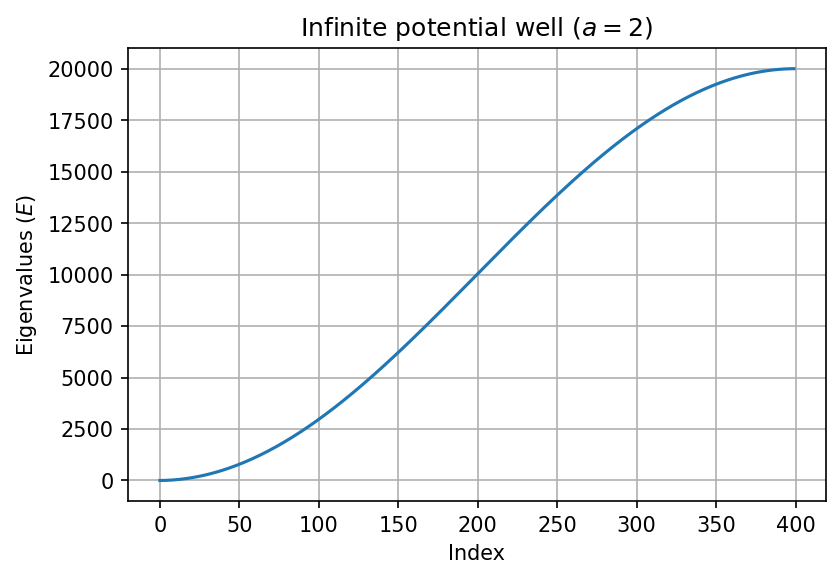

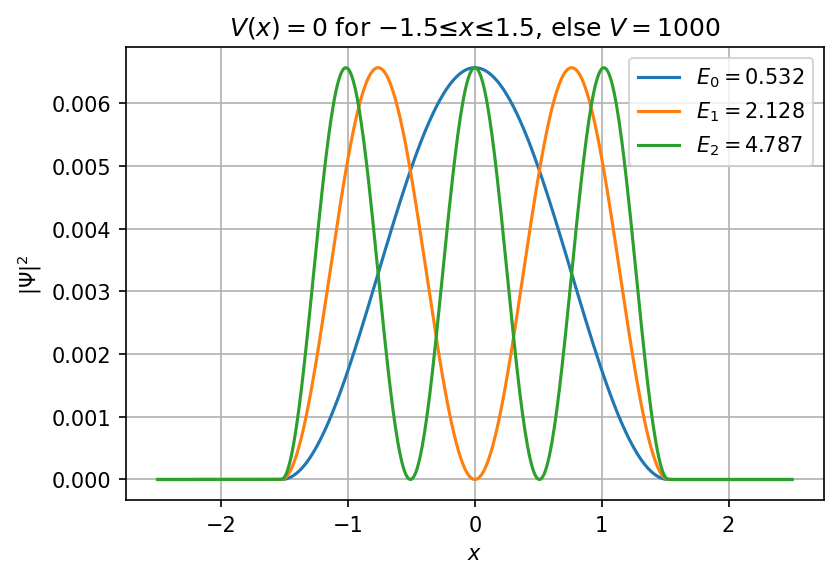

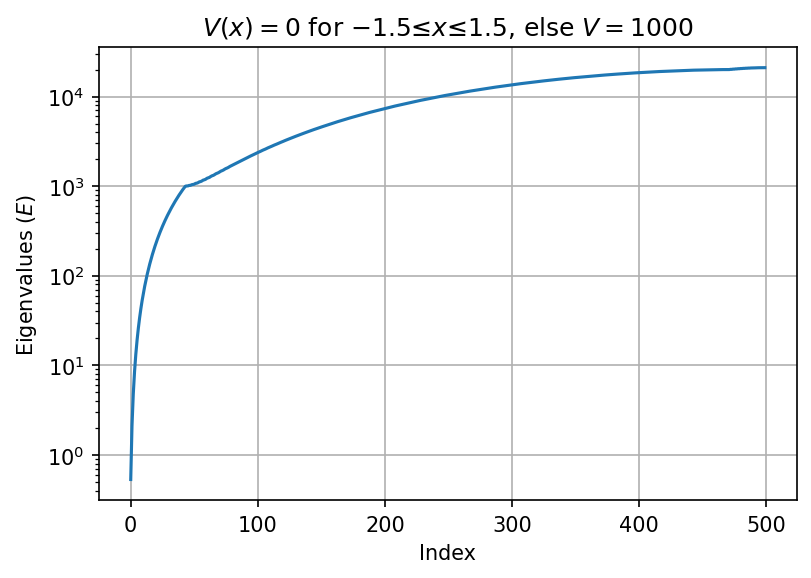

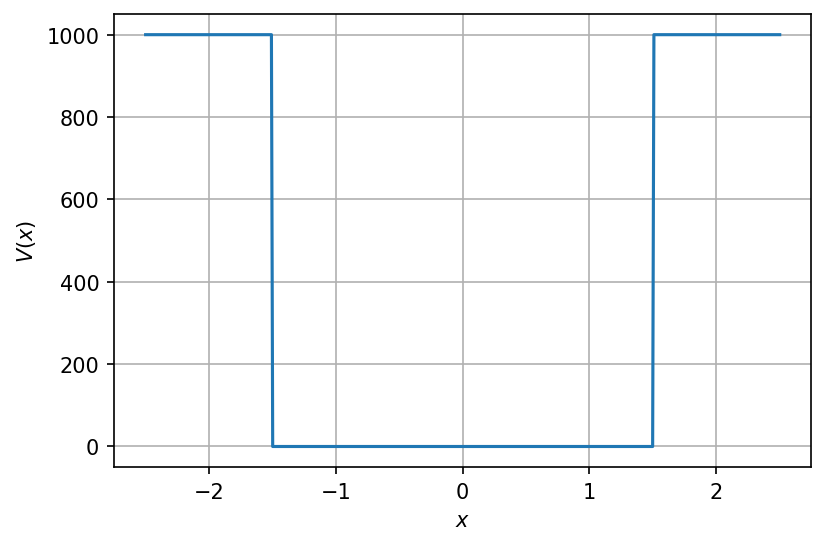

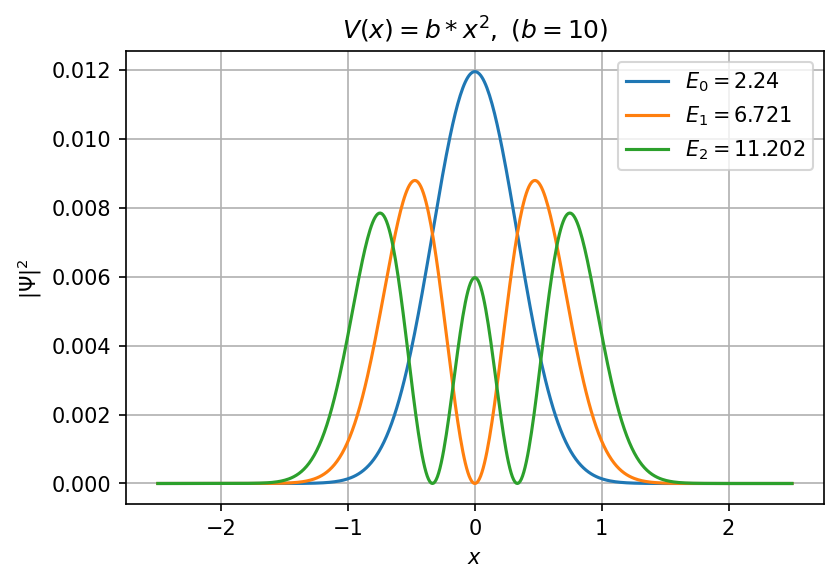

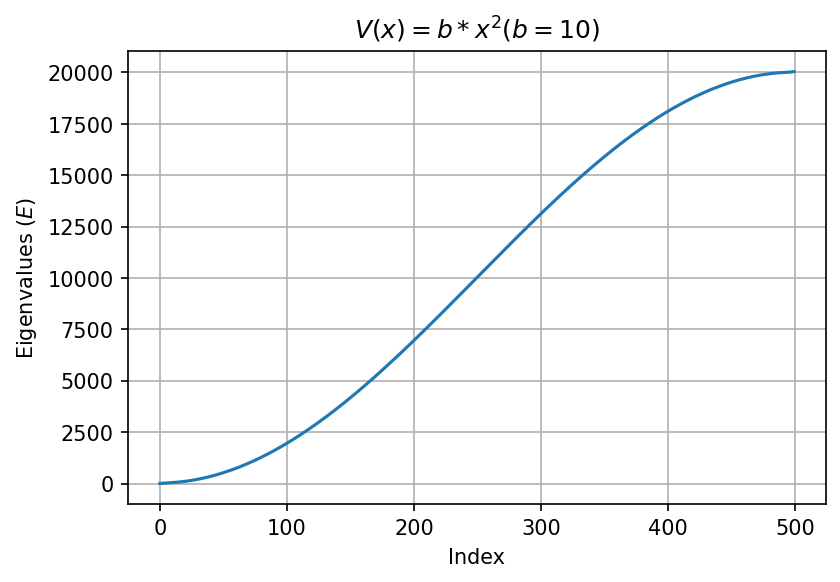

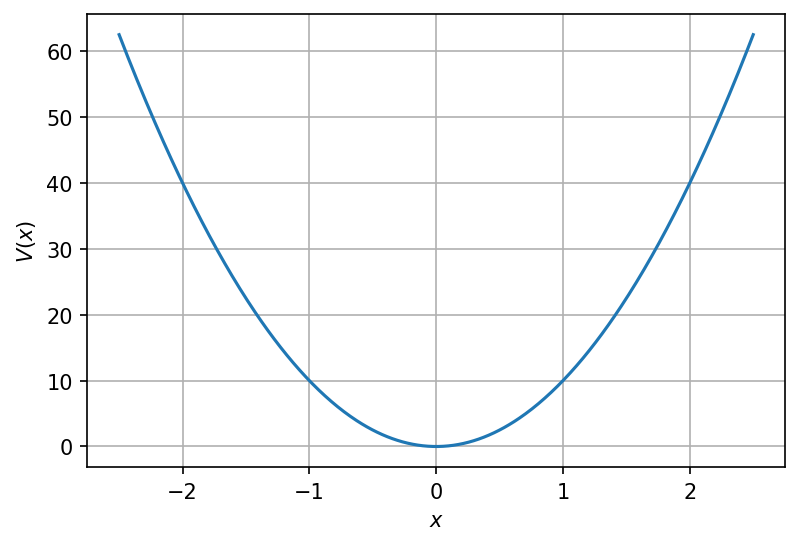

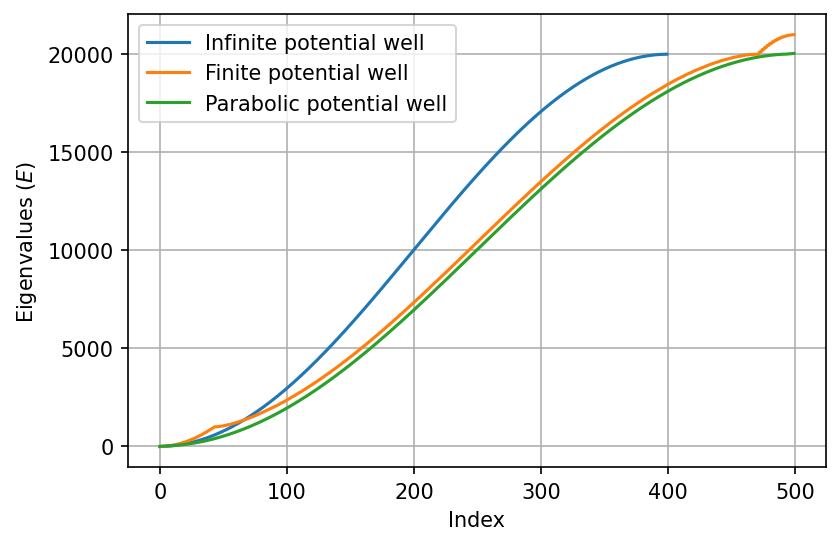

In [6]:
value_cache = []

L = 5
dims = 500
potential = 100
a =  2 ### from the middle only needed in inf potential
pot_a = 2 ### from the boundary only needed in finite potential
b = 10
infinite = True
function = False
index_list = [0,1,2]
vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)

eigs = sorter(values, vectors)
value_cache.append(eigs[0].copy())

legendlist = []
counter = 0
for i in index_list:
    plt.plot(np.linspace(-1/2*L, 1/2*L,dims),np.abs(eigs[1][:,i])**2)
    legendlist.append('$E_' + str(counter) + ' = ' + str(round(eigs[0][i],3)) + '$')
    counter = counter + 1
plt.legend(tuple(legendlist))
plt.xlabel('$x$')
plt.ylabel('$|Ψ|^2$')
plt.grid(True)
plt.title('Infinite potential well $(a = ' + str(a)  + ')$: numerical')
plt.show()


n_list = [1,2,3]
for n in n_list:
    plt.plot(np.linspace(-a, a,dims), np.abs(analytic(a,n,np.linspace(-a, a,dims)))**2)
plt.xlim(-1/2*L, 1/2*L)
plt.xlabel('$x$')
plt.ylabel('$|Ψ|^2$')
plt.grid(True)
plt.legend(tuple('$E_' + str(n) + ' = ' + str(np.round(n**2 * np.pi**2 /((2*a)**2 * 2),3)) + '$' for n in n_list) )
plt.title('Infinite potential well $(a = ' + str(a)  + ')$: analytic')
plt.show()

plt.plot(eigs[0])
plt.xlabel('Index')
plt.ylabel('Eigenvalues ($E$)')
plt.grid(True)
plt.title('Infinite potential well ($a = ' + str(a)  + ')$')
plt.show()

L = 5
dims = 500
potential = 1000
a =  2 ### from the middle only needed in inf potential
pot_a = 1 ### from the boundary only needed in finite potential
b = 10
infinite = False
function = False
index_list = [0,1,2]
vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)
eigs = sorter(values, vectors)
value_cache.append(eigs[0].copy())
legendlist = []
counter = 0
for i in index_list:
    plt.plot(np.linspace(-1/2*L, 1/2*L,dims),np.abs(eigs[1][:,i])**2)
    legendlist.append('$E_' + str(counter) + ' = ' + str(round(eigs[0][i],3)) + '$')
    counter = counter + 1
plt.legend(tuple(legendlist))
plt.xlabel('$x$')
plt.ylabel('$|Ψ|^2$')
plt.grid(True)
plt.title('$V(x) = 0$ for $' + str(-(np.round(1/2*L - pot_a,2))) + ' ≤ x ≤ '  + str(np.round(1/2*L - pot_a,3)) + '$, else $V = ' + str(potential) + '$' )
plt.show()

plt.plot(eigs[0])
plt.xlabel('Index')
plt.ylabel('Eigenvalues ($E$)')
plt.grid(True)
plt.title('$V(x) = 0$ for $' + str(-(np.round(1/2*L - pot_a,2))) + ' ≤ x ≤ '  + str(np.round(1/2*L - pot_a,3)) + '$, else $V = ' + str(potential) + '$')
plt.yscale('log')
plt.show()

plt.plot(np.linspace(-1/2*L, 1/2*L,dims),V)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.show()

L = 5
dims = 500
potential = 100
a =  2 ### from the middle only needed in inf potential
pot_a = 2 ### from the boundary only needed in finite potential
b = 10
infinite = False
function = True
index_list = [0,1,2]
vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)
eigs = sorter(values, vectors)
value_cache.append(eigs[0].copy())
legendlist = []
counter = 0
for i in index_list:
    plt.plot(np.linspace(-1/2*L, 1/2*L,dims),np.abs(eigs[1][:,i])**2)
    legendlist.append('$E_' + str(counter) + ' = ' + str(round(eigs[0][i],3)) + '$')
    counter = counter + 1
plt.legend(tuple(legendlist))
plt.xlabel('$x$')
plt.ylabel('$|Ψ|^2$')
plt.grid(True)
plt.title('$V(x) = b * x^2,$ $(b = ' + str(b) + ')$')
plt.show()

plt.plot(eigs[0])
plt.xlabel('Index')
plt.ylabel('Eigenvalues ($E$)')
plt.grid(True)
plt.title('$V(x) = b * x^2 (b = ' + str(b) + ')$')
plt.show()

plt.plot(np.linspace(-1/2*L, 1/2*L,dims),V)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.show()

for i in value_cache:
    plt.plot(i)
plt.xlabel('Index')
plt.ylabel('Eigenvalues ($E$)')
plt.grid(True)
plt.legend(('Infinite potential well','Finite potential well','Parabolic potential well'))
plt.show()



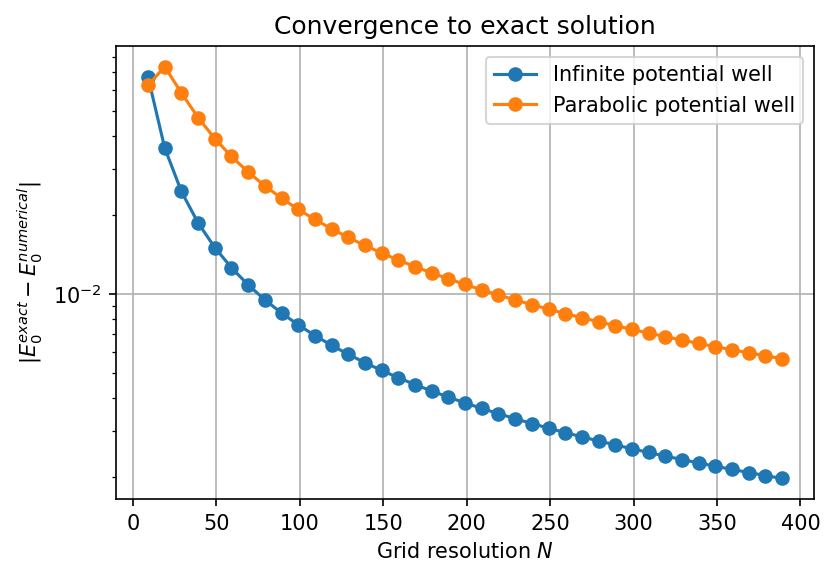

In [16]:
dims_list = np.linspace(10,400,40)
dims_list = np.asarray([int(x) for x in dims_list])
eigenvalues_list = [[],[],[]]
for dims in dims_list:
    L = 5
    potential = 100
    a =  2 ### from the middle only needed in inf potential
    pot_a = 2 ### from the boundary only needed in finite potential
    b = 10
    infinite = True
    function = False
    vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
    values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)
    eigs = sorter(values, vectors)
    eigenvalues_list[0].append(eigs[0][0])
    L = 5
    potential = 800
    a =  2 ### from the middle only needed in inf potential
    pot_a = 1 ### from the boundary only needed in finite potential
    b = 10
    infinite = False
    function = False
    vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
    values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)
    eigs = sorter(values, vectors)
    eigenvalues_list[1].append(eigs[0][0])
    L = 5
    potential = 100
    a =  2 ### from the middle only needed in inf potential
    pot_a = 2 ### from the boundary only needed in finite potential
    b = 10
    infinite = False
    function = True
    vector, dx, V = vector_creator(L,dims,a, potential, pot_a, function = function, b = b)
    values, vectors = vector_to_matrix(vector,dx, V, infinite = infinite)
    eigs = sorter(values, vectors)
    eigenvalues_list[2].append(eigs[0][0])
eigenvalues_list = np.asarray(eigenvalues_list)
counter = 0
for i in eigenvalues_list:
    if counter == 0:
        plt.plot(dims_list[0:-1] - 1,np.abs(i[0:-1] - 1**2 * np.pi**2 /((2*a)**2 * 2)), marker = 'o')
    elif counter == 2:
        plt.plot(dims_list[0:-1] - 1,np.abs(i[0:-1] - (1/2)*np.sqrt(2*b)), marker = 'o')
    counter = counter + 1
plt.xlabel('Grid resolution $N$')
plt.ylabel('$|E^{exact}_0 - E^{numerical}_0|$')
plt.grid(True)
plt.legend(('Infinite potential well','Parabolic potential well'))
plt.yscale('log')
plt.title('Convergence to exact solution')
plt.show()

# Solving the time-independent Schrödinger equation using the variational method with 2 polynomial basis functions for the infinite square-well potential

In [12]:
def wav1(x,l = 1):
    return x**2*(l-x)
    
def wav2(x,l = 1):
    return x*(l-x)**2

def Hwav1(x,l = 1):
    return -1/2*(2*l -6*x)

def Hwav2(x,l = 1):
    return -1/2*(-4*l + 6*x)

def HS(wav1 ,wav2,Hwav1 ,Hwav2 ,l = 1):
    x = np.linspace(0,l,1000)
    
    ### Hamiltian matrix elements
    wav1Hwav1 = lambda x: wav1(x)*Hwav1(x)
    wav1Hwav2 = lambda x: wav1(x)*Hwav2(x)
    wav2Hwav1 = lambda x: wav2(x)*Hwav1(x)
    wav2Hwav2 = lambda x: wav2(x)*Hwav2(x)
    
    H = [wav1Hwav1,wav1Hwav2,wav2Hwav1,wav2Hwav2]
    for h in range(len(H)):
        H[h] = integrate.quad(H[h],0,l)[0]
    H = np.asarray(H)
    H = H.reshape((2,2))
    
    ### Overlap matrix
    wav1wav1 = lambda x: wav1(x)*wav1(x)
    wav1wav2 = lambda x: wav1(x)*wav2(x)
    wav2wav1 = lambda x: wav2(x)*wav1(x)
    wav2wav2 = lambda x: wav2(x)*wav2(x)
    
    S = [wav1wav1,wav1wav2,wav2wav1,wav2wav2]
    for s in range(len(S)):
        S[s] = integrate.quad(S[s],0,l)[0]
    S = np.asarray(S)
    S = S.reshape((2,2))
    
    return H,S

H,S = HS(wav1,wav2,Hwav1,Hwav2)
print('H and S pre-orthonormalisation:')
print(H)
print(S)

### Lowdin orthonormalisation
inversqrt = linalg.sqrtm(np.linalg.inv(S))

def lowdin(fun1,fun2,inversqrt = inversqrt):
    M = inversqrt
    return (lambda x: M[0,0]*fun1(x) + M[1,0]*fun2(x), lambda x: M[0,1]*fun1(x) + M[1,1]*fun2(x))

wav1, wav2 = lowdin(wav1,wav2)
Hwav1,Hwav2 = lowdin(Hwav1,Hwav2)
####

H,S = HS(wav1,wav2,Hwav1,Hwav2)
print('\nH and S post-orthonormalisation:')
print(H)
print(S)

H and S pre-orthonormalisation:
[[0.06666667 0.01666667]
 [0.01666667 0.06666667]]
[[0.00952381 0.00714286]
 [0.00714286 0.00952381]]

H and S post-orthonormalisation:
[[13. -8.]
 [-8. 13.]]
[[1.00000000e+00 1.94289029e-16]
 [1.94289029e-16 1.00000000e+00]]


In [13]:
eigs, vecs = np.linalg.eig(np.dot(np.linalg.inv(S),H))

def order(eigs,vecs):
    new_eigs  = []
    new_vecs = []
    eigs = list(eigs)
    vecs = list(vecs.T)
    for i in range(len(eigs)):
        cache = min(eigs)
        index = eigs.index(cache)
        new_eigs.append(cache)
        new_vecs.append(vecs[index])
        del eigs[index]
        del vecs[index]
    return np.asarray(new_eigs), np.asarray(new_vecs).T

eigs,vecs = order(eigs,vecs)

def wavcofs(x,cofs,wav1 = wav1, wav2 = wav2):
    return cofs[0]*wav1(x) + cofs[1]*wav2(x)



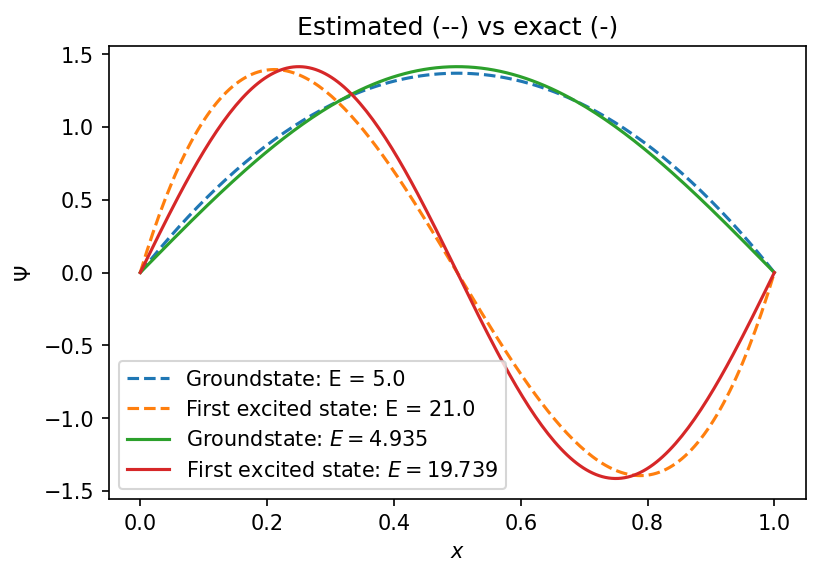

In [14]:
x = np.linspace(0,1,200)
groundstate = wavcofs(x,vecs[:,0])
excited = wavcofs(x,vecs[:,1])
plt.plot(x,-groundstate, linestyle = '--')
plt.plot(x,-excited, linestyle = '--')
legendlist = ['Groundstate: E = ' + str(np.round(eigs[0],3)),'First excited state: E = '
            + str(np.round(eigs[1],3))]

def exact(x,n,l = 1):
    return (-1/2*(-(n**2*np.pi**2)/(l**2)),np.sqrt(2/l)*np.sin(n*np.pi*x/l))

groundstate1 = exact(x,1)
excited1 = exact(x,2)

Eg,Wg = groundstate1
Ef,Wf = excited1

plt.plot(x,Wg)
plt.plot(x,Wf)
legendlist.append('Groundstate: $E = ' + str(np.round(Eg,3))+'$')
legendlist.append('First excited state: $E = '+ str(np.round(Ef,3))+'$')
plt.legend((legendlist))
plt.xlabel('$x$')
plt.ylabel('$\Psi$')
plt.title('Estimated (--) vs exact (-)')
plt.show()